# Pediatric Ulcerative Colitis metagenomics | ML applications

## Setup

Let’s begin by importing the modules we’ll need.

In [26]:
import sys
sys.path.append('/home/labs/elinav/uria/mprod_package/')

from mprod.dimensionality_reduction import TCAM
from mprod import table2tensor
from importlib import reload


import pandas as pd
import numpy as np
import scipy


import random
from multiprocessing import Pool
from sklearn.metrics import pairwise_distances
from itertools import combinations, islice

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from IPython.display import  display_markdown


import pandas as pd
import dateutil
import datetime
from itertools import combinations, product

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_roc_curve, auc
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier
from sklearn.metrics import auc

import os
os.environ["PATH"] += os.pathsep + '/apps/RH7U2/gnu/texlive/2016/bin/x86_64-linux/' # For printing latex


plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['mathtext.rm'] = 'sans'

mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans',
    'pgf.rcfonts': False,
})

%matplotlib inline



### PERMANOVA functions

In [27]:

def pairwise_melt_meta(meta, data):
    _dm = pairwise_distances(data.loc[meta['SampleID']])
    for i in range(_dm.shape[0]):
        _dm[i,i:] = None
    _dm_df = pd.DataFrame(_dm, index = meta['SampleID'].rename('sample1'), columns=meta['SampleID'].rename('sample2'))

    _dm_melt = pd.melt(_dm_df.reset_index(), id_vars=['sample1'], value_name='d').dropna()

    metacols = ['rGroup','Participant', 'SampleID']
    _dm_melt2 = meta.loc[:, metacols].merge(_dm_melt, right_on = 'sample2', left_on = 'SampleID', how = 'right').drop('SampleID', axis=1)
    _dm_melt_meta = meta.loc[:, metacols].merge(_dm_melt2, right_on = 'sample1', left_on= 'SampleID', how = 'right', suffixes = ("1","2")).drop('SampleID', axis=1)
    return _dm_melt_meta

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)


def ss_total(data):
    return (data['d']**2).sum()

def ss_within(data):
    if 'rGroup11' in data.columns:
        # Group11 Group22 are the permuted labels of samples in Group1, Group2 resp'
        return data.query('rGroup11 == rGroup22').groupby('rGroup11')['d'].apply(lambda x: (x**2).sum()).sum()
    else:
        return data.query('rGroup1 == rGroup2').groupby('rGroup1')['d'].apply(lambda x: (x**2).sum()).sum()

def ss_between(data, ss_t):
    return ss_t - ss_within(data)

def Fstat(data, ss_t = None, N = None):
    # p = 2 as there are always 2 groups in our cases
    if N is None:
        N = len(set(data['sample1'].tolist() + data['sample2'].tolist()))
    if ss_t is None:
        ss_t = ss_total(data)
    ss_w = ss_within(data)
    ss_b = ss_t - ss_w
    return ss_b / (ss_w / (N - 2))


def gen_rperm(meta, r):
    _mice_map = meta.loc[:, ['Participant', 'rGroup']].copy()
    _mice_map.drop_duplicates(inplace=True)
    _mice_map.index = _mice_map['Participant']
    gsizes = _mice_map.groupby('rGroup').size()
    g1size, g1label, g2label = gsizes[0], gsizes.index[0], gsizes.index[-1]
    

    for _ in range(r):
        _mice_map['Group_perm'] = np.random.permutation(_mice_map['rGroup'])
        yield _mice_map['Group_perm'].to_dict()

def _permfs(args):
    __data, tv, N, permdict = args
    _data = __data.copy()
    _data['rGroup11'] = _data['Participant1'].map(permdict)
    _data['rGroup22'] = _data['Participant2'].map(permdict)
    return Fstat(_data, tv, N)


def run_permanova(meta, data, nperms = 1000):
    _dmm = pairwise_melt_meta(meta, data)

    _dmm['rGroup11'] = _dmm['rGroup1'].copy()
    _dmm['rGroup22'] = _dmm['rGroup2'].copy()

    N = len(set(_dmm['sample1'].tolist() + _dmm['sample2'].tolist()))
    total_var = ss_total(_dmm)
    fs_obs = Fstat(_dmm, total_var, N)

    
    with Pool(processes=5) as p:
        fs_perms = p.imap(_permfs, ((_dmm, total_var, N, dd) for dd in gen_rperm(meta, nperms)))
        fs_perms = np.array([x for x in fs_perms])

    return ((fs_perms > fs_obs).sum() ) / (nperms )     

### ML workflow

In [28]:

class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self
    
class DataframeTransformer(TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def transform(self,X,y=None, **transform_params):
        Xcp = X.copy()
        return pd.DataFrame(self.transformer.transform(Xcp), index = X.index, columns= X.columns)

    def fit(self, X, y=None, **fit_params):
        self.transformer = self.transformer.fit(X.values)
        return self


class IndexMuncher(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X,y=None, modemap = []):
        return self
    
    def transform(self, X, y = None):
        datacols = X.columns.tolist()
        blmean = X.copy()
        blmean = blmean.reset_index().groupby(['SubjectID','Week'])[datacols].apply(lambda x:x.iloc[0,:])
        return blmean


    def fit_transform(self, X, y = None, modemap = []):
        self = self.fit(X, y, modemap)
        Xt = self.transform(X, y)
        modemap += Xt.index.to_list()
        return Xt
    
    
class RAFilter(BaseEstimator, TransformerMixin):
    def __init__(self, capval = 5e-2):
        self._f_list = []
        self.capval = capval
        pass

    def fit(self, X,y=None, modemap = []):
        X_t = X.copy()
        self._f_list = [i for i in range(X_t.shape[1]) if (X_t.iloc[:,i] > self.capval).sum() > X_t.shape[0]*0.1 ]
        return self
    
    def transform(self, X, y = None):
        X_t = X.iloc[:,self._f_list].copy()
        X_t[X_t < self.capval] = self.capval
        X_t = 100 * X_t / X_t.values.sum(axis=1,keepdims = True)
        return X_t


    def fit_transform(self, X, y = None, modemap = []):
        self = self.fit(X, y, modemap)
        Xt = self.transform(X, y)
        modemap += Xt.index.to_list()
        return Xt
    

    
def blmean_dataframe(X, y = None, cap = 0):
    blmean = (X + cap).groupby(level=['SubjectID']).apply(lambda x:x / x.loc[x.index.get_level_values('Week') == 0].mean())
    blmean = np.log2(blmean)
    return blmean

def index_trans(X, y = None, **kwargs):
    datacols = X.columns.tolist()
    blmean = X.copy()
    blmean = blmean.reset_index(level = ['SubjectID']).groupby(['SubjectID','Week'])[datacols].apply(lambda x:x.iloc[0,:])
    return blmean


class CompletePipeline(BaseEstimator, TransformerMixin):
    def __init__(self,preproc2d, mwt):
        self.preproc2d = preproc2d
        self.mwt = mwt
        
    def fit(self, X,y=None):
        self.preproc2d = self.preproc2d.fit(X,y)
        
        x1 = self.preproc2d.transform(X)
        modemap = x1.index.tolist()
        
        tensor, mode1_mapping, mode3_mapping = table2tensor(x1, modemap)
        mwt_tensor = self.mwt.fit_transform(tensor.data)
        return self
    
    def transform(self, X, y = None):
        x1 = self.preproc2d.transform(X)
        modemap = x1.index.tolist()
        tensor, mode1_mapping, mode3_mapping = table2tensor(x1, modemap)
        mwt_tensor = self.mwt.transform(tensor)
        Xt = pd.DataFrame(mwt_tensor).rename(index = mode1_mapping).sort_index()
        return Xt


from sklearn.decomposition import PCA

def exec_model(model, x_train, x_test, y_train, y_test, ax, lists):
    mean_fpr = np.linspace(0, 1, 100)
    
    # fit model
    train_blmean = model.fit(x_train, y_train.copy())

    # inspect model roc
    viz = plot_roc_curve(model, x_test, y_test.copy(),
                     name='F{}'.format(i+1),
                     alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    
    # append roc data
    lists['tprs'].append(interp_tpr)
    lists['aucs'].append(viz.roc_auc)
    xys_i = pd.DataFrame([viz.fpr, viz.tpr], index = ['FPR','TPR']).T
    xys_i['rep'] = i+1
    lists['dflist_roc'].append(xys_i)

def blmean_query_raw(X, y = None, week = 12):
    X_t = X.loc[X.index.get_level_values('Week').isin([0,week]) ].copy()
    return X_t

def blmean_query(X, y = None, week = 12):
    X_t = X.loc[X.index.get_level_values('Week').isin([week]) ].copy()
    return X_t


class PCAWrapper(BaseEstimator, TransformerMixin):
    def __init__(self,energy):
        self.energy = energy
        self._n_components = None
        self.pca = PCA()
        
    def fit(self, X,y=None):
        self.pca = self.pca.fit(X,y)
        
        cum_sum = self.pca.explained_variance_ratio_.cumsum()
        valid_idx = np.where(cum_sum >= self.energy)[0]
        self._n_components = valid_idx[cum_sum[valid_idx].argmin()] + 1
        self._n_components = min(self._n_components, len(self.pca.explained_variance_ratio_))        
        return self
    
    def transform(self, X, y = None):
        Xt = self.pca.transform(X)
        return Xt[:,:self._n_components]
    

## Dataset

The following example is adapted from this study [1]. They evaluated the role of the gut microbiome in disease course for 405 pediatric, new-onset, treatment-naive UC patients. Patients were monitored for 1 year upon treatment initiation, and microbial taxonomic composition was analyzed from fecal samples and rectal samples using 16S rRNA gene amplicon sequencing. In this example we will analyze the longitudinal stool samples and the association with two different factors:
 
1. Treatment
    * 5ASA: 5-aminosalicylic acid (5-ASA) compound, mesalamine
    * CS-Oral: corticosteroids (oral administration), followed by mesalamine
    * CS-IV: corticosteroids (intravenous administration), followed by mesalamine
2. Disease state
    * Flare
    * Remission
    
Fecal samples were collected at baseline (week 0, prior to treatment) and 3 follow-up time points (4, 12, and 52 weeks after treatment initiation).

In [29]:
data_raw = pd.read_csv("./Schirmer2018.tsv", index_col=[0,1], sep="\t"
                       , dtype={'Week':int})

meta = pd.read_csv("./metadata_Schirmer2018.tsv", index_col=[0], sep="\t")

display(data_raw.head())
display(meta.head())


k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__Ruminococcaceae-g__Oscillospira-s__-OTU_310886  \
SubjectID Week                                                                                                               
P_10343   0                                              0.000000                                                            
          4                                              0.000183                                                            
          12                                             0.000000                                                            
          52                                             0.000000                                                            
P_10897   0                                              0.000423                                                            

                k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__Peptostreptococcaceae-g__-s__-OTU_531374  \
SubjectID Week                                                                                                         
P_10343   0                                              0.000000                                                      
          4                                              0.000000                                                      
          12                                             0.000000                                                      
          52                                             0.000097                                                      
P_10897   0                                              0.000000                                                      

                k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__-g__-s__-OTU_366584  \
SubjectID Week                                                                                    
P_10343   0                                              0.000000                                 
          4                                              0.008966                                 
          12                                             0.000000                                 
          52                                             0.000000                                 
P_10897   0                                              0.000059                                 

                k__Bacteria-p__Proteobacteria-c__Betaproteobacteria-o__Burkholderiales-f__Alcaligenaceae-g__Sutterella-s__-OTU_173726  \
SubjectID Week                                                                                                                          
P_10343   0                                                   0.0                                                                       
          4                                                   0.0                                                                       
          12                                                  0.0                                                                       
          52                                                  0.0                                                                       
P_10897   0                                                   0.0                                                                       

                k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__Ruminococcaceae-g__-s__-OTU_366794  \
SubjectID Week                                                                                                   
P_10343   0                                                   0.0                                                
          4                                                   0.0                                                
          12                                                  0.0                                                
          52                                                  0.0   

,Treatment,Remission
SubjectID,,
P_10343,5ASA,No remission
P_10897,CS-Oral,Remission
P_1108,CS-Oral,Remission
P_11085,5ASA,Remission
P_11369,CS-IV,Remission


# TCAM and PCA analysis

Scatter plots for 2 leading factors of TCAM for the whole dataset (left); PCA computed for log2 ratio of week 12 and baseline (middle); PCA computed for log2 ratio of week 52 and baseline (right). Points are colored according to remission (REM) and flare (FLR) status.

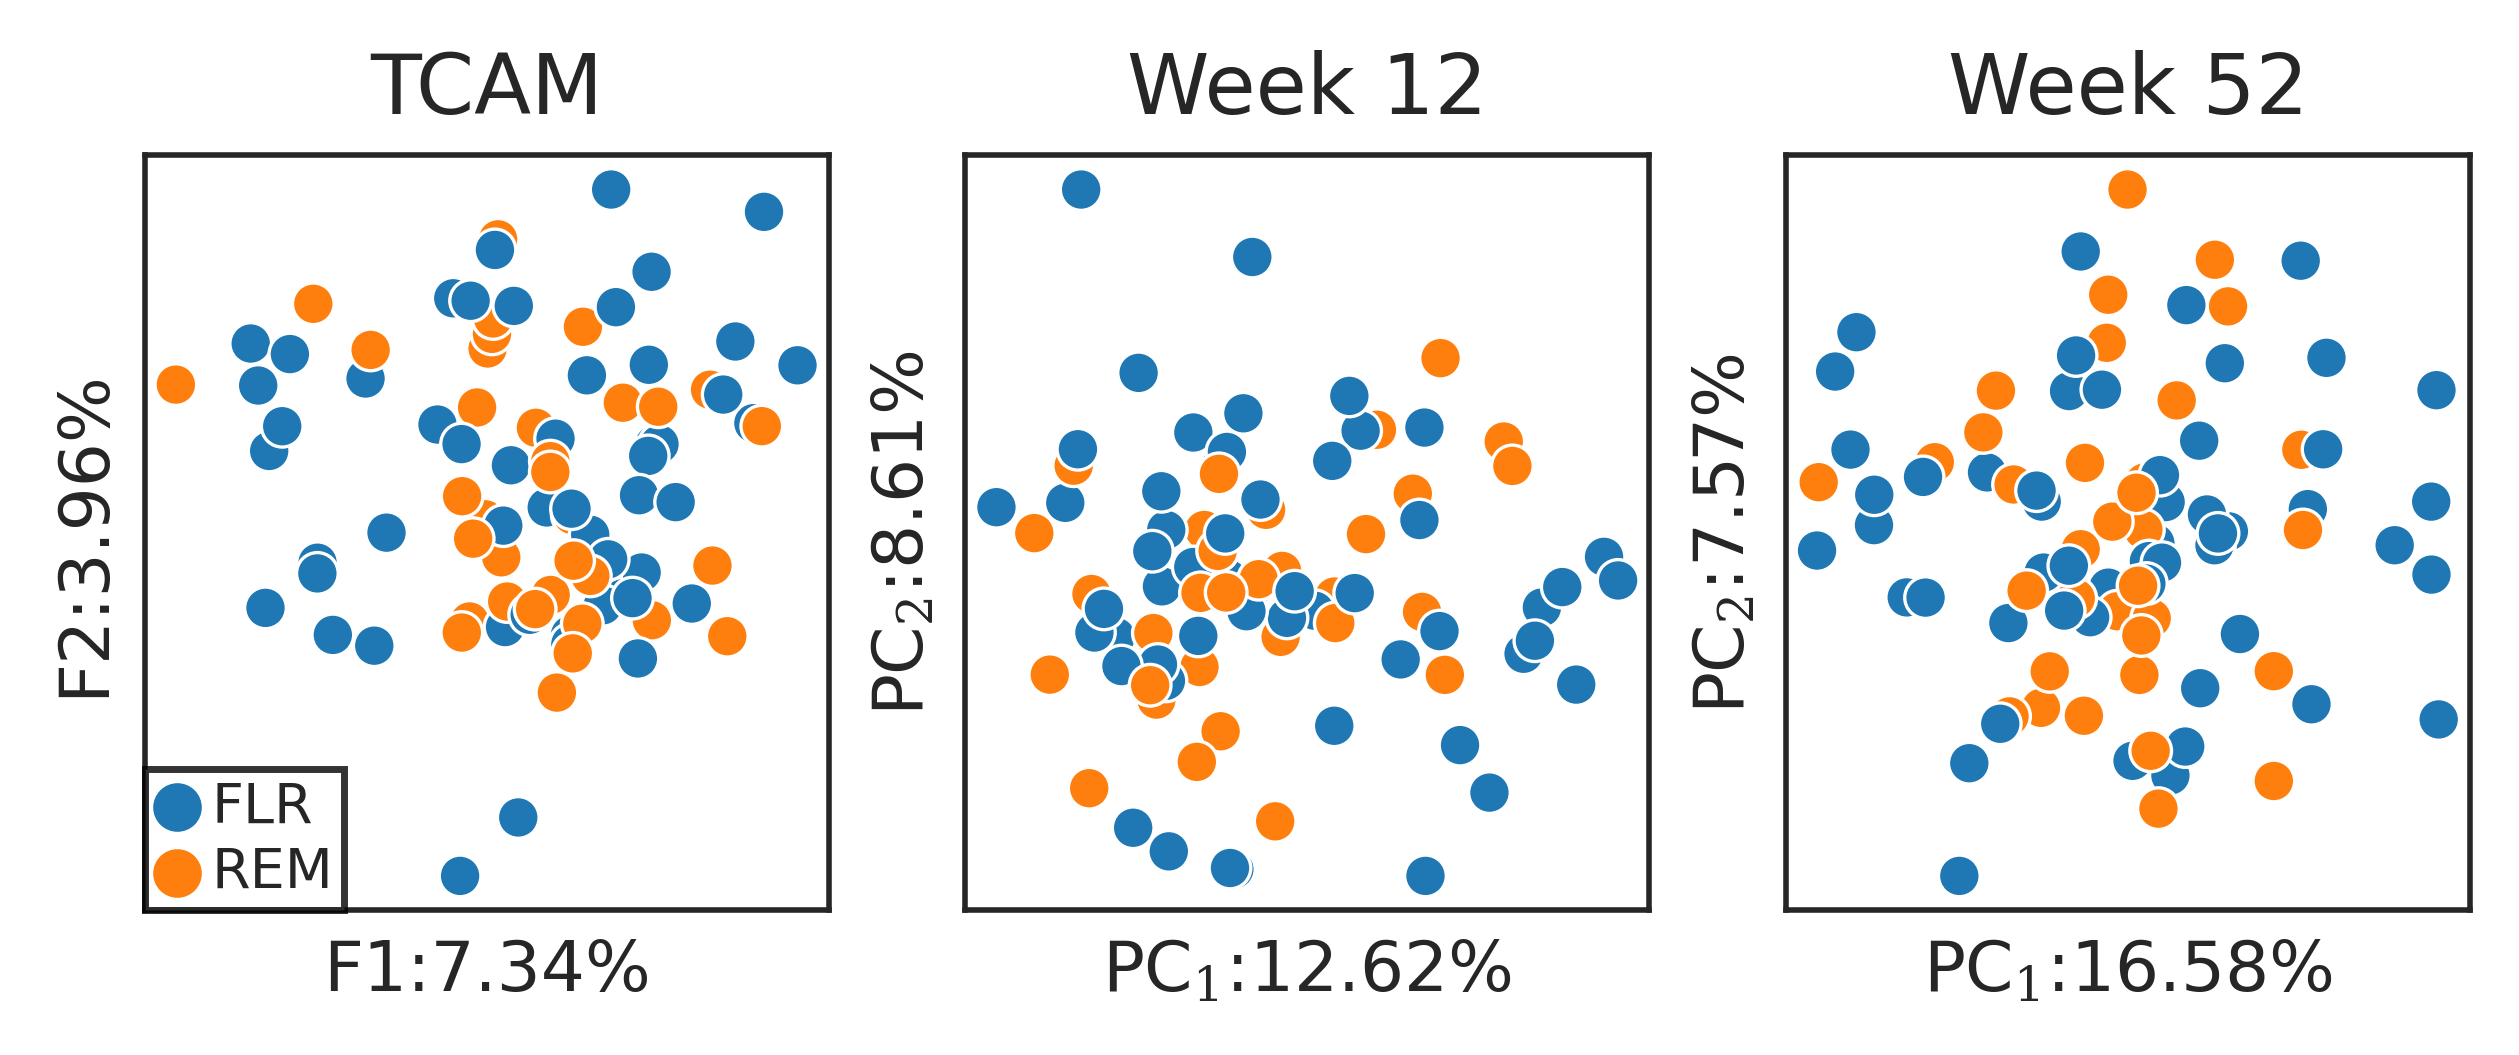

In [33]:
blmean_dataframe_funtrans = FunctionTransformer(blmean_dataframe)

data_raw = pd.read_csv("./Schirmer2018.tsv", index_col=[0,1], sep="\t"
                       , dtype={'Week':int})
data_raw = 100 * data_raw / data_raw.values.sum(axis=1, keepdims=True)


meta = pd.read_csv("./metadata_Schirmer2018.tsv", index_col=[0], sep="\t")

table = data_raw.copy()
pr_meta = meta.loc[table.index.get_level_values('SubjectID'),'Remission'].reset_index().copy()
cap = 5e-3

mwt_obj = TCAM(n_components=0.8)

tca_red = CompletePipeline(preproc2d = Pipeline([('raf',RAFilter(capval=cap)),
                                             ('blmean', blmean_dataframe_funtrans),
                                             ('ss2', DataframeTransformer(StandardScaler(with_std=False))),
                                             ('index_transform', IndexMuncher())])
                       , mwt = mwt_obj  )

table_trans = tca_red.fit_transform(table).rename(index = mode1_reverse_map)
table_trans.columns = [f'F{i}:{np.round(100*val, 2)}%' for i,val in enumerate(tca_red.mwt.explained_variance_ratio_, start = 1)]


# define w12 model
p12 = Pipeline([('qraw', DataframeTransformer(FunctionTransformer(blmean_query_raw, kw_args={'week':12}))),
                ('raf',RAFilter(capval=cap)),
                ('blmean', blmean_dataframe_funtrans),
                ('q', FunctionTransformer(blmean_query, kw_args={'week':12})),
                ('ss2', DataframeTransformer(StandardScaler(with_std=False)))])
t12 = p12.fit_transform(table)
pca12 = PCA()
pca12_table = pca12.fit_transform(t12)
pca12_table = pd.DataFrame(pca12_table, index = t12.index)
pca12_table.columns = ['PC$_{'+str(i)+'}$:'+ f'{np.round(100*v,2)}%' for i,v in enumerate(pca12.explained_variance_ratio_,start = 1)]



# # define w52 model
p52 = Pipeline([('qraw', DataframeTransformer(FunctionTransformer(blmean_query_raw, kw_args={'week':52}))),
                ('raf',RAFilter(capval=cap)),
                ('blmean', blmean_dataframe_funtrans),
                ('q', FunctionTransformer(blmean_query, kw_args={'week':52})),
                ('ss2', DataframeTransformer(StandardScaler(with_std=False)))])
t52 = p52.fit_transform(table)
pca52 = PCA()
pca52_table = pca52.fit_transform(t52)
pca52_table = pd.DataFrame(pca52_table, index = t52.index)
pca52_table.columns = ['PC$_{'+str(i)+'}$:'+ f'{np.round(100*v,2)}%' for i,v in enumerate(pca52.explained_variance_ratio_,start = 1)]

meta_graph = pr_meta.loc[:, ['SubjectID','Remission']].copy().drop_duplicates()
meta_graph = meta_graph.rename(columns={'Remission':"Group"})
meta_graph['Group'] = meta_graph['Group'].apply(lambda x: 'REM' if x.startswith('Rem') else 'FLR')

fig, axe = plt.subplots(1,3, figsize = [6,2], dpi = 500)

sns.scatterplot(data = table_trans.merge(meta_graph, left_index = True, right_on = 'SubjectID')
                , x = table_trans.columns[0],y = table_trans.columns[1], hue = 'Group', ax = axe[0])
axe[0].set_title('TCAM')
axe[0].legend(loc='lower left', handlelength = .75,handletextpad = .25, fontsize = 8,borderaxespad=.0,borderpad=.2, fancybox=False,edgecolor='k',labelspacing=.2, title = False)


sns.scatterplot(data = pca12_table.reset_index(level=-1,drop=True).merge(meta_graph, left_index = True, right_on = 'SubjectID')
                , x = pca12_table.columns[0],y = pca12_table.columns[1], hue = 'Group', ax = axe[1])
axe[1].set_title('Week 12')
axe[1].legend_.set_visible(False)

sns.scatterplot(data = pca52_table.reset_index(level=-1,drop=True).merge(meta_graph, left_index = True, right_on = 'SubjectID')
                , x = pca52_table.columns[0],y = pca52_table.columns[1], hue = 'Group', ax = axe[2])
axe[2].set_title('Week 52')
axe[2].legend_.set_visible(False)


for i in range(3):
    axe[i].set_xticks([])
    axe[i].set_yticks([])





PERMANOVA test for the TCAM 

In [36]:

meta_perm = pd.read_csv("./metadata_Schirmer2018.tsv", sep="\t")
meta_perm.rename(columns = {'SubjectID':'Participant'},inplace = True)
meta_perm.rename(columns = {'Remission':'Group'},inplace = True)
meta_perm['SampleID'] = meta_perm['Participant']

n_factors =  (np.cumsum(tca_red.mwt.explained_variance_ratio_) < .8).sum() + 1 # 20% variance



meta_perm.rename(columns = {'Group':'rGroup'},inplace = True)
table_comp = df_tca.loc[meta_perm['SampleID']].copy()
n_all = meta_perm.loc[meta_perm['rGroup'].isin(["No remission","Remission"])].shape[0]
n_perm = 1000
p = run_permanova(meta_perm, table_trans.loc[meta_comp['SampleID']].iloc[:,:n_factors].copy(), nperms = n_perm)
p

0.725

# Remission status classification

iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
key TCAM
key Week 12
key Week 52


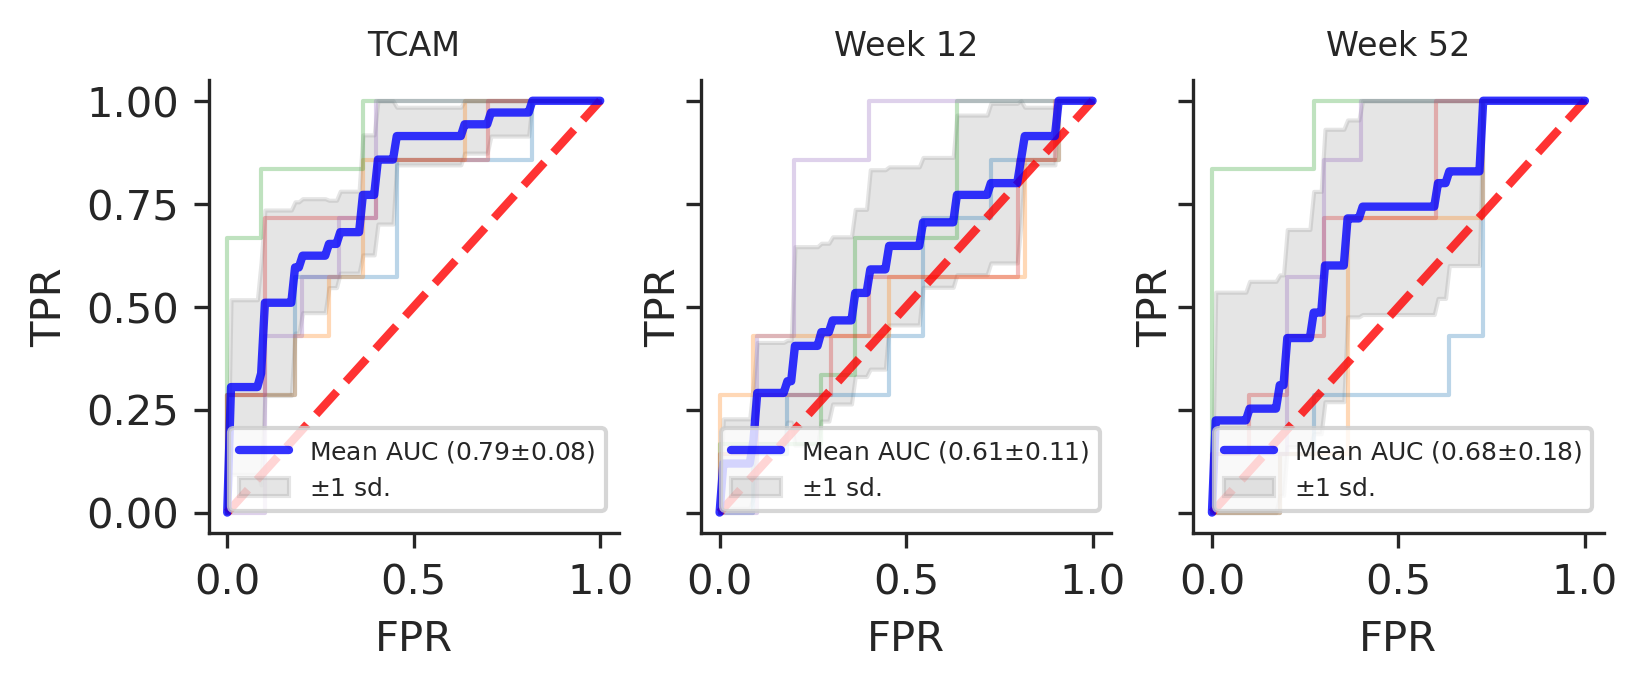

In [37]:
rs = 1234

cap = 5e-3

cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=rs)


sid_ser = pr_meta.loc[:, ['SubjectID','Remission']].copy().drop_duplicates()
sid_ser.index = sid_ser['SubjectID'].values
sid_ser = 1*(sid_ser['Remission'] == 'Remission')
sid_ser = sid_ser[table.index.get_level_values('SubjectID').unique()]


auc_lists = {
    'TCAM': {'tprs':[],'aucs':[],'rep':[],'dflist_roc':[]},
    'Week 12': {'tprs':[],'aucs':[],'rep':[],'dflist_roc':[]},
    'Week 52': {'tprs':[],'aucs':[],'rep':[],'dflist_roc':[]},
}
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1,3,sharex=True, sharey=True)
fig.set_size_inches([6,2])
fig.set_dpi(300)

for i, (train_iloc, test_iloc) in enumerate(cv.split(sid_ser.index.values,sid_ser.values, sid_ser.values)):

    # define tcam based model
    mwt_obj = TCAM(n_components=0.8)
    ppp = CompletePipeline(preproc2d = Pipeline([('raf',RAFilter(capval=cap)),
                                                 ('blmean', blmean_dataframe_funtrans),
                                                 ('ss2', DataframeTransformer(StandardScaler(with_std=False))),
                                                 ('index_transform', IndexMuncher())])
                           , mwt = mwt_obj  )

    mpp = Pipeline([('ppp', ppp),
                    ('mmt',DataframeTransformer(MinMaxScaler(clip = True))),
                    ('clf', MLPClassifier(hidden_layer_sizes=(1000, ),
                                          batch_size=train_iloc.size//3,
                                          max_iter=500,
                                          random_state=rs))])
    
    # define w12 model
    model_12 = Pipeline([('qraw', DataframeTransformer(FunctionTransformer(blmean_query_raw, kw_args={'week':12}))),
                         ('raf',RAFilter(capval=cap)),
                         ('blmean', blmean_dataframe_funtrans),
                         ('q', FunctionTransformer(blmean_query, kw_args={'week':12})),
                         ('ss2', DataframeTransformer(StandardScaler(with_std=False))),
                         ('pca', PCAWrapper(energy=.8)),
                         ('clf', MLPClassifier(hidden_layer_sizes=(1000, ),
                                               batch_size=train_iloc.size//3,
                                               max_iter=500,
                                               random_state=rs))])
    
    # define w52 model
    model_52 = Pipeline([('qraw', DataframeTransformer(FunctionTransformer(blmean_query_raw, kw_args={'week':52}))),
                         ('raf',RAFilter(capval=cap)),
                         ('blmean', blmean_dataframe_funtrans),
                         ('q', FunctionTransformer(blmean_query, kw_args={'week':52})),
                         ('ss2', DataframeTransformer(StandardScaler(with_std=False))),
                         ('pca', PCAWrapper(energy=.8)),
                         ('clf', MLPClassifier(hidden_layer_sizes=(1000, ),
                                               batch_size=train_iloc.size//3,
                                               max_iter=500,
                                               random_state=rs))])

    # split data
    train_iloc = np.sort(train_iloc)
    test_iloc = np.sort(test_iloc)
    
    train_id = sid_ser.index[train_iloc].copy().sort_values()
    y_train = sid_ser[train_iloc].copy().sort_index()
    test_id = sid_ser.index[test_iloc].copy().sort_values()
    y_test = sid_ser[test_iloc].copy().sort_index()
    
    x_train_long = table.loc[ table.index.get_level_values('SubjectID').isin(train_id)].copy()
    x_train_long = x_train_long.sort_index(level=['SubjectID','Week'])

    x_test_long = table.loc[ table.index.get_level_values('SubjectID').isin(test_id)].copy()
    x_test_long = x_test_long.sort_index(level=['SubjectID','Week'])
    
    # run models
    exec_model(mpp, x_train_long.copy(), x_test_long.copy(), y_train.copy(), y_test.copy(), ax[0], auc_lists['TCAM'])
    exec_model(model_12, x_train_long.copy(), x_test_long.copy(), y_train.copy(), y_test.copy(), ax[1], auc_lists['Week 12'])
    exec_model(model_52, x_train_long.copy(), x_test_long.copy(), y_train.copy(), y_test.copy(), ax[2], auc_lists['Week 52'])
    print("iter:",i+1)
    
    
for i in range(3):

    ax[i].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    
    key = ['TCAM','Week 12','Week 52'][i]
    print('key', key)
    mean_tpr = np.mean(auc_lists[key]['tprs'], axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(auc_lists[key]['aucs'])
    ax[i].plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean AUC (%0.2f$\pm$%0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(auc_lists[key]['tprs'], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[i].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$1 sd.')
    
    hands, labs = ax[i].get_legend_handles_labels()
    hands = [l for l in hands][-2:]
    labs = [l for l in labs][-2:]
    
    ax[i].legend(hands, labs, fontsize = 6, loc=[0.05,.05], frameon=True)
    ax[i].set_ylabel('TPR')
    ax[i].set_xlabel('FPR')
    ax[i].set_title(key, fontdict={'size':8})


sns.despine()



plt.show()



## Variable importance 

**Only for the sake of demonstrating the variable importance** 
, we reduce the features set to the 500 otus with highes maximal value.
Generally, such practice should be avoided as it allows information from the test dataset to leak into the training.

We do it only so that sklearn `permutation_importance` finishes in finite time.



train 0
train 1
train 2
train 3
train 4


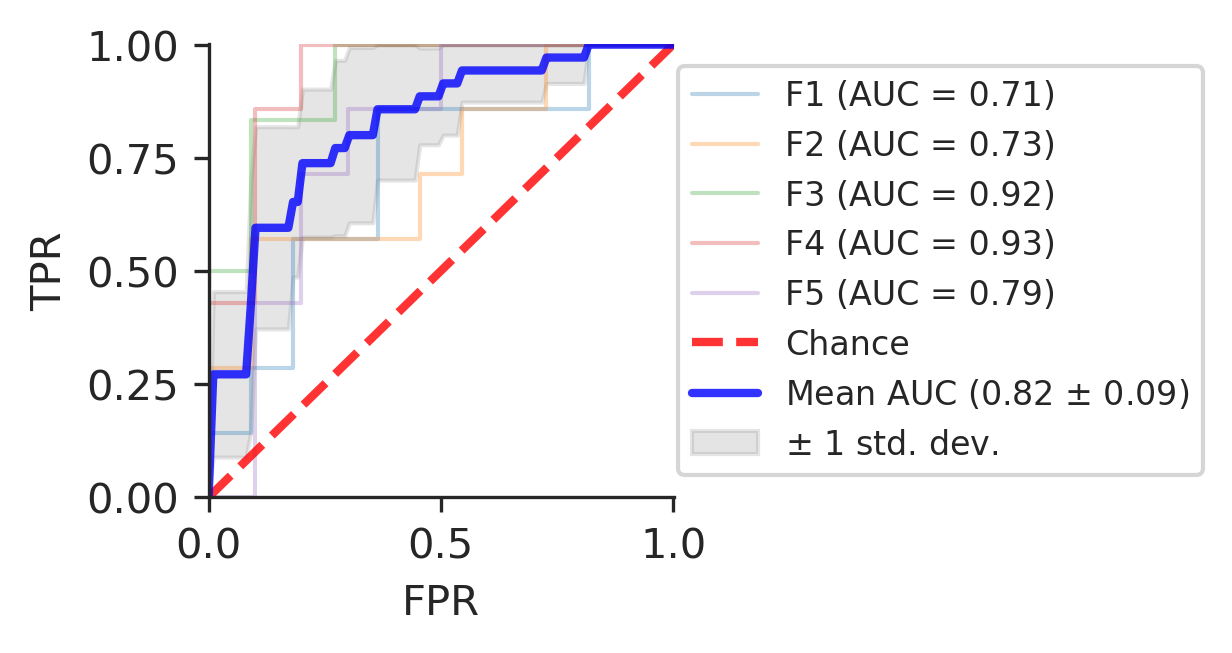

In [38]:
rs = 1234

cap = 5e-3

blmean_dataframe_funtrans = FunctionTransformer(blmean_dataframe)


data_vi = pd.read_csv("Schirmer2018.tsv", index_col=[0,1], sep="\t"
                       , dtype={'Week':int})
data_vi = data_vi.groupby(["SubjectID","Week"]).mean()
data_vi = 100 * data_vi / data_vi.values.sum(axis=1, keepdims=True)
data_vi = data_vi.loc[:, data_vi.max().nlargest(500).index]
data_vi = 100 * data_vi / data_vi.values.sum(axis=1, keepdims=True)






preproc = Pipeline([('raf',RAFilter(capval=cap)),
                    ('blmean', blmean_dataframe_funtrans),
                    ('ss2', DataframeTransformer(StandardScaler(with_std=False))),
                    ('index_transform', IndexMuncher())
                   ])



cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=rs)


sid_ser = pr_meta.loc[:, ['SubjectID','Remission']].copy().drop_duplicates()
sid_ser.index = sid_ser['SubjectID'].values
sid_ser = 1*(sid_ser['Remission'] == 'Remission')
sid_ser = sid_ser[data_vi.index.get_level_values('SubjectID').unique()]

importance = []

tprs = []
fprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
fig.set_size_inches([2,2])
fig.set_dpi(300)
dflist_roc = []

for i, (train_iloc, test_iloc) in enumerate(cv.split(sid_ser.index.values,sid_ser.values, sid_ser.values)):

    mwt_obj = TCAM(n_components=0.8)
    ppp = CompletePipeline(preproc2d = preproc, mwt = mwt_obj  )
    clfstep = MLPClassifier(hidden_layer_sizes=(1000, ),batch_size=train_iloc.size//3, max_iter=500, random_state=rs)
    mpp = Pipeline([('ppp', ppp), ('mmt', DataframeTransformer(MinMaxScaler(clip = True))), ('clf', clfstep)])
    train_iloc = np.sort(train_iloc)
    test_iloc = np.sort(test_iloc)
    
    train_id = sid_ser.index[train_iloc].copy().sort_values()
    y_train = sid_ser[train_iloc].copy().sort_index()
    test_id = sid_ser.index[test_iloc].copy().sort_values()
    y_test = sid_ser[test_iloc].copy().sort_index()
    
    x_train_long = data_vi.loc[ data_vi.index.get_level_values('SubjectID').isin(train_id)].copy()
    x_train_long = x_train_long.sort_index(level=['SubjectID','Week'])

    x_test_long = data_vi.loc[ data_vi.index.get_level_values('SubjectID').isin(test_id)].copy()
    x_test_long = x_test_long.sort_index(level=['SubjectID','Week'])
    
    print("train",i)
    train_blmean = mpp.fit(x_train_long, y_train)
    viz = plot_roc_curve(mpp, x_test_long, y_test.copy(),
                     name='F{}'.format(i+1),
                     alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    xys_i = pd.DataFrame([viz.fpr, viz.tpr], index = ['FPR','TPR']).T
    xys_i['rep'] = i+1
    
    dflist_roc.append(xys_i)
    
    importance.append(permutation_importance(mpp, x_test_long, y_test.copy(), random_state=rs,n_jobs=5 ))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean AUC (%0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.0, 1.001], ylim=[-0.0, 1.001])#,
ax.legend( fontsize = 8, ncol=1, loc =[1.01,.05] )
ax.set_ylabel('TPR')
ax.set_xlabel('FPR')
sns.despine()

plt.show()



### Top ranked features
Bar plot showing importance scores of top 5% ranked features.

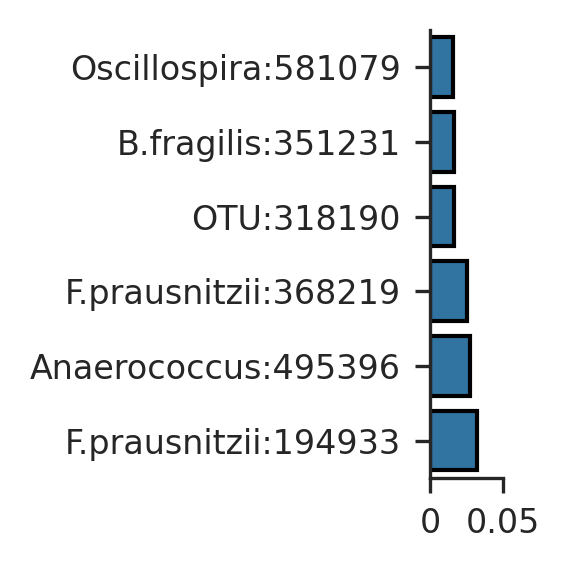

In [39]:
def read_rep(i):
    rep0_imp = pd.Series(importance[i]['importances_mean'].copy(), index = data_vi.columns )
    rep0_imp = rep0_imp[rep0_imp.abs() > 0].sort_values()
    return rep0_imp.rename(i)

rep_imp = pd.concat([read_rep(i) for i in range(len(importance))], axis=1)

def remap_imp_index(ind):
    name_lst = ind.split("-")[-3:]
    name_lst = [n.split("__")[-1].replace("_"," ") for n in name_lst]

    if len(name_lst[0]) > 0 and len(name_lst[1]) > 0:
        name_lst[0] = name_lst[0][0] + "."
    title = name_lst[0] + name_lst[1] + ":" + name_lst[2]

    graph_t = title.replace("_"," ").replace(":OTU ",":")
    if graph_t.startswith(":"):
        graph_t = "OTU"+graph_t

    return graph_t

fig, ax = plt.subplots(dpi = 300)
fig.set_size_inches([2,2])

imp_plot = rep_imp.loc[rep_imp.fillna(0).mean(axis=1) > rep_imp.fillna(0).mean(axis=1).quantile(.95)].copy()

imp_plot = imp_plot.loc[imp_plot.isnull().sum(axis=1) < 1].copy()
imp_plot = imp_plot.loc[imp_plot.mean(axis=1) > 0]
imp_plot = imp_plot.loc[imp_plot.mean(axis=1).sort_values().index].mean(axis=1).to_frame()

imp_plot_renamed = imp_plot.copy()

imp_plot_renamed.index= imp_plot_renamed.index.map(remap_imp_index)

sns.barplot(data = imp_plot_renamed.T + 1e-8, orient='h', color= sns.color_palette()[0], ax = ax, edgecolor = 'k')
ax.tick_params(axis='both', which='both', labelsize=8)
ax.set_xticks([0,5e-2])
ax.set_xticklabels(['0',5e-2])
sns.despine()
fig.tight_layout()



### TCAM based on top 5% important variables

[]

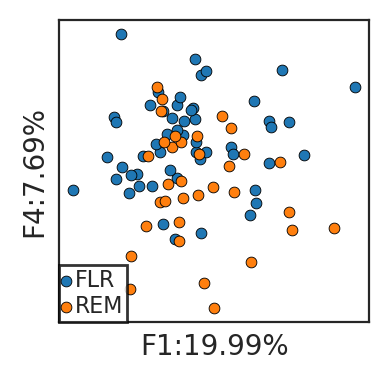

In [40]:
plt.rcParams['axes.autolimit_mode'] = 'data' # 'round_numbers'

rmap = data_vi.index.tolist()


## Selecting top important features
tbl_imp = data_vi.copy()
tbl_imp = tbl_imp.loc[:,imp_plot.index].copy()
tbl_imp[tbl_imp < 5e-5] = 5e-5 # cap values to avoid division by zero



blmean_data = blmean_dataframe(tbl_imp)


tensor_data, mode1_map, mode3_map = table2tensor(blmean_data)
mode1_reverse_map = {val:k for k,val in mode1_map.items()}
tcam = TCAM(n_components=None)
transformed_data = tcam.fit_transform(tensor_data)

df_tca = pd.DataFrame(transformed_data).rename(index = mode1_reverse_map)
rounded_expvar = np.round(100*tcam.explained_variance_ratio_, 2)
df_tca.columns = [f'F{i}:{val}%' for i,val in enumerate(rounded_expvar, start = 1)]

xi, yi = 0,3
xc,yc = df_tca.columns[xi], df_tca.columns[yi]

# trans_important
trans_important = df_tca.reset_index().rename(columns = {'index':'SubjectID'}).merge(pr_meta.drop_duplicates(), how = 'left')

fig, ax = plt.subplots(dpi = 200)
fig.set_size_inches([2,2])
sns.scatterplot(data = trans_important.query("Remission != 'Remission'"),x=xc,y=yc, s = 15, edgecolor = 'k'
                , ax = ax, label = 'FLR')
sns.scatterplot(data = trans_important.query("Remission == 'Remission'"),x=xc,y=yc, s = 15, edgecolor = 'k'
                , ax = ax, label = 'REM')
ax.legend(loc='lower left', handlelength = .25,handletextpad = .25, fontsize = 8,borderaxespad=.0,borderpad=.2, fancybox=False,edgecolor='k',labelspacing=.1)
ax.set_yticks([], minor = False)
ax.set_xticks([], minor = False)

### Relative abundace of discriminating features 
Time series of relative abundance levels, highlighting the differences in trajectories of the features contributing to the remission status classification model.

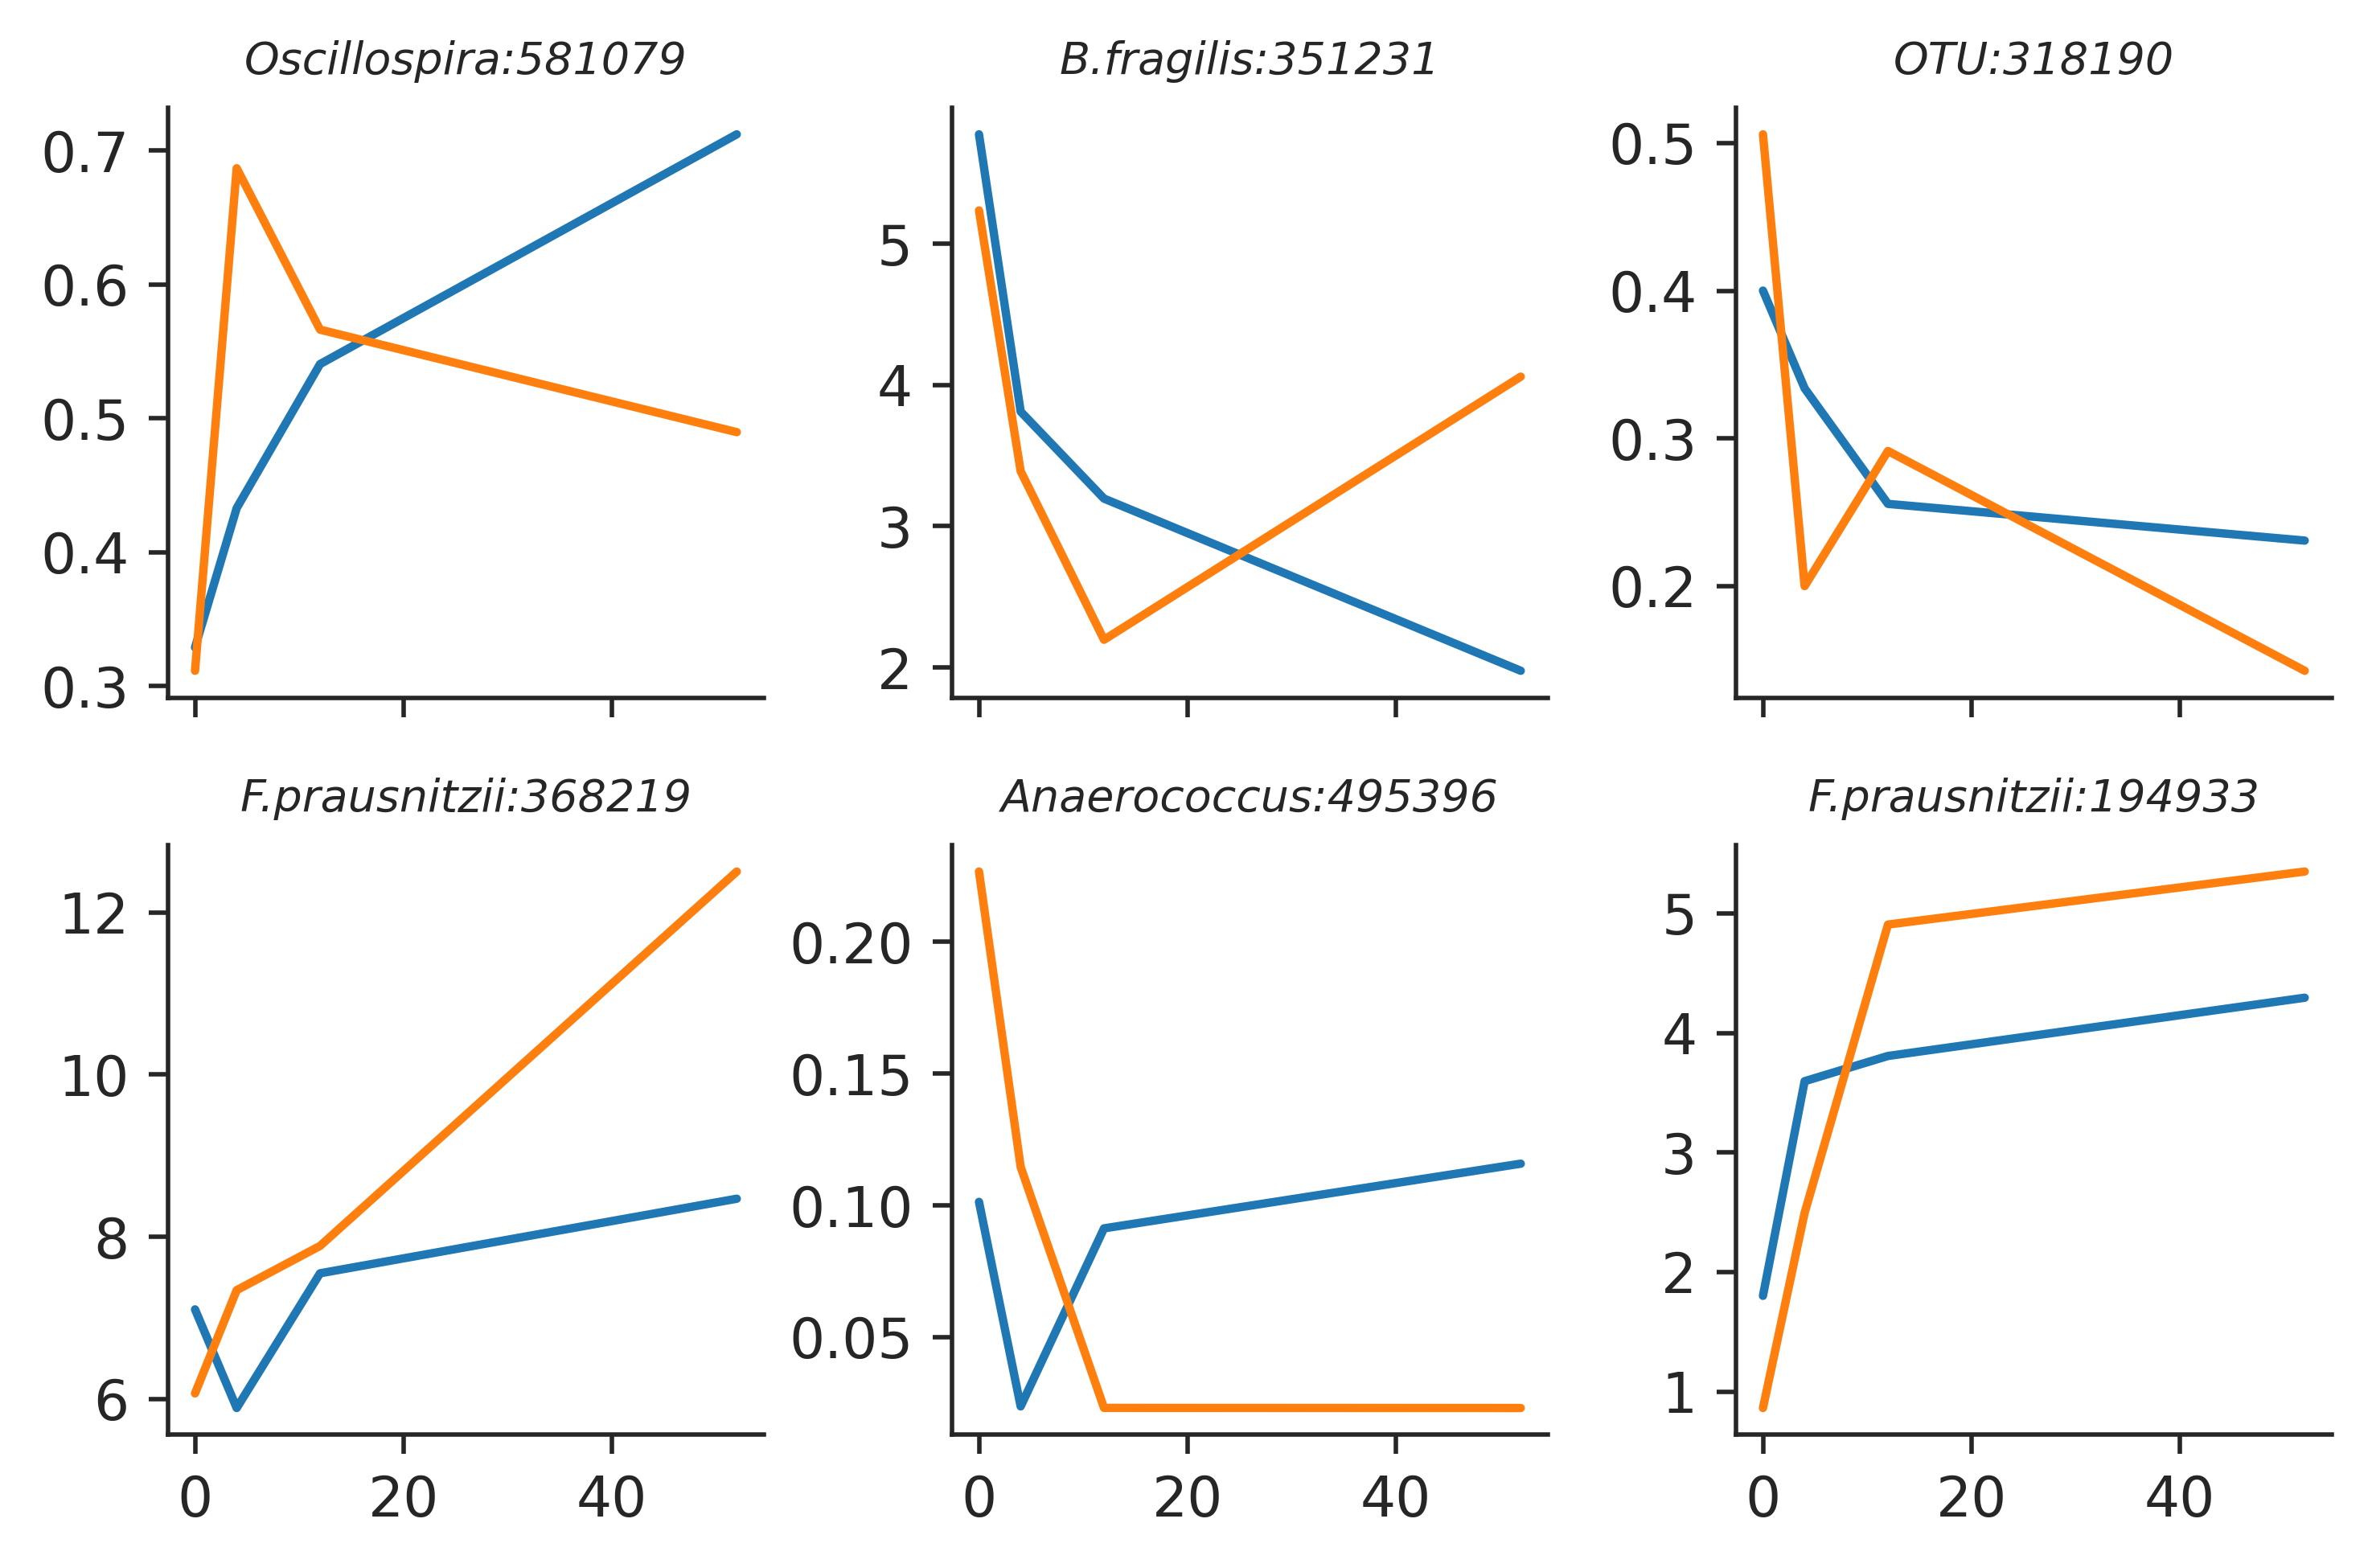

In [41]:
ts_data = pr_meta.merge(tbl_imp.loc[:,imp_plot.index].reset_index(), on = ['SubjectID']).groupby(['Remission','SubjectID','Week']).mean()

fig, axe = plt.subplots(2,3, sharex=True, figsize=[6,4], dpi = 500)
e=0

for i,f in enumerate(imp_plot.index):
    e = i//3
    tsdata = (ts_data[f]).copy().reset_index()
    tsdata['Remission'] = tsdata['Remission'].apply(lambda x: 'FLR' if x.startswith('No') else 'REM')
    sns.lineplot(data = tsdata, x='Week', y = f, ci = None
                 , hue='Remission', hue_order = ['FLR','REM']
                 , ax = axe[e][i%3])
    axe[e][i%3].legend_.set_visible(False)
    axe[e][i%3].set_title(remap_imp_index(f), fontdict = {"fontstyle":"italic", "size" : 8})
    axe[e][i%3].set_xlabel('')
    axe[e][i%3].set_ylabel('')


sns.despine()
plt.tight_layout()


## References
<a id="1">[1]</a> 
Schirmer M. et al (2018). 
Compositional and Temporal Changes in the Gut Microbiome of Pediatric Ulcerative Colitis Patients Are Linked to Disease Course.
Cell Host & Microbe, Volume 24, Issue 4, Pages 472-474